## Imports and Configurations

In [2]:
# Connect my drive to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# All imports
import pandas as pd
import matplotlib.pyplot as plt
import math 
import copy
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Conv2D, MaxPool2D
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from mlxtend.plotting import plot_confusion_matrix
import pickle

In [4]:
# Define path
base_path = '/content/drive/MyDrive/owlytics'
file_name = 'dataset.csv'

## EDA

In [5]:
df = pd.read_csv(f'{base_path}/{file_name}')
# Leave only relevat activities: Walking, Running, Nordic walking
relevant_activities = [4,5,7]
df = df[df["activityID"].isin(relevant_activities)]
# Add a label column, mostly for the EDA
df["label_name"] = df["activityID"].apply(lambda x: "Walking" if x == 4 else "Running" if x == 5 else "Nordic Walking")

### Let's look at the data first
During the EDA I'll print some insights, search for them!

In [6]:
df.head()

,timestamp,subject_id,activityID,hand_accX,hand_accY,hand_accZ,ankle_accX,ankle_accY,ankle_accZ,label_name
277508,2780.72,1,4,-9.37273,2.94536,1.46774,9.73205,-1.60687,-1.48858,Walking
277509,2780.73,1,4,-9.44162,2.94762,1.65914,9.72925,-1.72013,-1.56508,Walking
277510,2780.74,1,4,-9.48289,3.02278,1.54281,9.65440,-1.71965,-1.56585,Walking
277511,2780.75,1,4,-9.55900,2.94749,1.54192,9.65161,-1.83292,-1.64236,Walking
277512,2780.76,1,4,-9.44831,2.94594,1.46661,9.50631,-1.83325,-1.48949,Walking


In [7]:
df.describe()

,timestamp,subject_id,activityID,hand_accX,hand_accY,hand_accZ,ankle_accX,ankle_accY,ankle_accZ
count,461284.000000,461284.000000,461284.000000,452454.000000,452454.000000,452454.000000,382402.000000,382402.000000,382402.000000
mean,2796.101128,4.230437,5.258357,-7.559847,3.799544,1.752507,12.387506,0.540031,-3.396198
std,466.621470,1.990183,1.363102,7.015735,10.873679,3.486356,8.280199,10.722925,5.288367
min,2050.920000,1.000000,4.000000,-145.367000,-104.301000,-101.452000,-112.150000,-155.256000,-156.179000
25%,2390.817500,3.000000,4.000000,-11.183100,0.631770,0.386699,8.962920,-2.393823,-4.898682
50%,2709.425000,4.000000,5.000000,-8.352465,3.206030,1.799155,10.869350,-0.247053,-3.032240
75%,3257.702500,6.000000,7.000000,-3.904045,6.657343,3.304025,16.073875,2.442877,-1.644612
max,4007.810000,7.000000,7.000000,47.631400,155.699000,67.009500,157.232000,153.633000,158.872000


In [8]:
print("I can allready spot that on the ankle, we have many missing values. Let's find where.")

I can allready spot that on the ankle, we have many missing values. Let's find where.


In [9]:
print("The next print will tell us how many values are missing for each subject and each activity")

The next print will tell us how many values are missing for each subject and each activity


In [10]:
sub_dic = {}
for idx, row in df.iterrows():
    if math.isnan(row["ankle_accX"]):
        subject_id, activityID = row["subject_id"], row["activityID"]
        s = f'Subject #{subject_id} Activity #{activityID}'
        if s not in sub_dic:
            sub_dic[s] = 0
        sub_dic[s] += 1
sub_dic

{'Subject #1 Activity #4': 242,
 'Subject #1 Activity #5': 72,
 'Subject #1 Activity #7': 233,
 'Subject #2 Activity #4': 230,
 'Subject #3 Activity #4': 363,
 'Subject #3 Activity #7': 235,
 'Subject #4 Activity #4': 357,
 'Subject #4 Activity #5': 277,
 'Subject #4 Activity #7': 213,
 'Subject #5 Activity #4': 25721,
 'Subject #5 Activity #5': 22825,
 'Subject #5 Activity #7': 26686,
 'Subject #6 Activity #4': 286,
 'Subject #6 Activity #5': 41,
 'Subject #6 Activity #7': 266,
 'Subject #7 Activity #4': 400,
 'Subject #7 Activity #5': 106,
 'Subject #7 Activity #7': 329}

In [11]:
print("Look like subject 5 is the problematic one. we will remove it later on. Let's continue the EDA")

Look like subject 5 is the problematic one. we will remove it later on. Let's continue the EDA


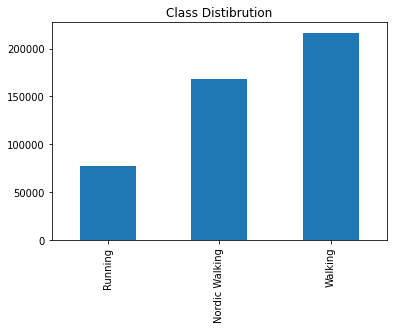

In [12]:
df["label_name"].value_counts().sort_values().plot(kind = 'bar')
plt.title("Class Distibrution")
plt.show()

In [13]:
print("The data isn't very balanced, however due to time consideration Il'l leave it like that.")
print("If I had more time, I would maybe undersample the data to the class with the least samples.")

The data isn't very balanced, however due to time consideration Il'l leave it like that.
If I had more time, I would maybe undersample the data to the class with the least samples.


In [14]:
print(f'Number of subjects: {df["subject_id"].nunique()}')
print(f'But we will remove Subject 5, so it will be 6')

Number of subjects: 7
But we will remove Subject 5, so it will be 6


In [15]:
print('We will continue by ploting each subject and how many samples we have of each class')

We will continue by ploting each subject and how many samples we have of each class


In [16]:
df.groupby(["subject_id", "activityID"]).count()["label_name"]

subject_id  activityID
1           4             32533
            5              9238
            7             29739
2           4             29036
3           4             31932
            5                 1
            7             27533
4           4             32033
            5             24646
            7             26271
5           4             25721
            5             22825
            7             26686
6           4             33720
            5              3692
            7             28725
7           4             31533
            5             16532
            7             28888
Name: label_name, dtype: int64

In [17]:
print("Subject 2 have only Walking samples")
print("Subject 3 have only 1 sample for Running")

Subject 2 have only Walking samples
Subject 3 have only 1 sample for Running


In [18]:
print("Removing Subject 5")

Removing Subject 5


In [19]:
df = pd.read_csv(f'{base_path}/{file_name}')
relevant_activities = [4,5,7]
subject_exclude = [5]
subjects_not_for_test = [2, 3]
df = df[df["activityID"].isin(relevant_activities)]
# Remove subject 5, has no ankle acc
df = df[~df["subject_id"].isin(subject_exclude)]
df["label_name"] = df["activityID"].apply(lambda x: "Walking" if x == 4 else "Running" if x == 5 else "Nordic Walking")
df.head()

,timestamp,subject_id,activityID,hand_accX,hand_accY,hand_accZ,ankle_accX,ankle_accY,ankle_accZ,label_name
277508,2780.72,1,4,-9.37273,2.94536,1.46774,9.73205,-1.60687,-1.48858,Walking
277509,2780.73,1,4,-9.44162,2.94762,1.65914,9.72925,-1.72013,-1.56508,Walking
277510,2780.74,1,4,-9.48289,3.02278,1.54281,9.65440,-1.71965,-1.56585,Walking
277511,2780.75,1,4,-9.55900,2.94749,1.54192,9.65161,-1.83292,-1.64236,Walking
277512,2780.76,1,4,-9.44831,2.94594,1.46661,9.50631,-1.83325,-1.48949,Walking


In [20]:
print("Let's look at the class distribution again")

Let's look at the class distribution again


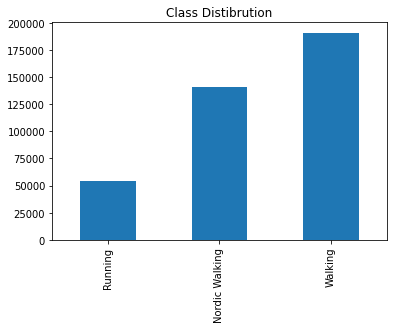

In [21]:
df["label_name"].value_counts().sort_values().plot(kind = 'bar')
plt.title("Class Distibrution")
plt.show()

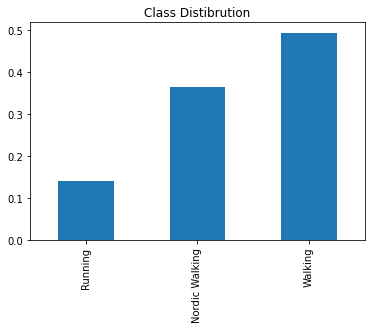

In [22]:
df["label_name"].value_counts(normalize=True).sort_values().plot(kind = 'bar')
plt.title("Class Distibrution")
plt.show()

In [23]:
print("Let's compare some sensors! We will look at subject 1")

Let's compare some sensors! We will look at subject 1


In [24]:
subject1 = df[df["subject_id"] == 1]
subject_1_walking = subject1[subject1["label_name"] == "Walking"]
subject_1_Running = subject1[subject1["label_name"] == "Running"]
subject_1_Nordic = subject1[subject1["label_name"] == "Nordic Walking"]
subject_1_Nordic.shape

(29739, 10)

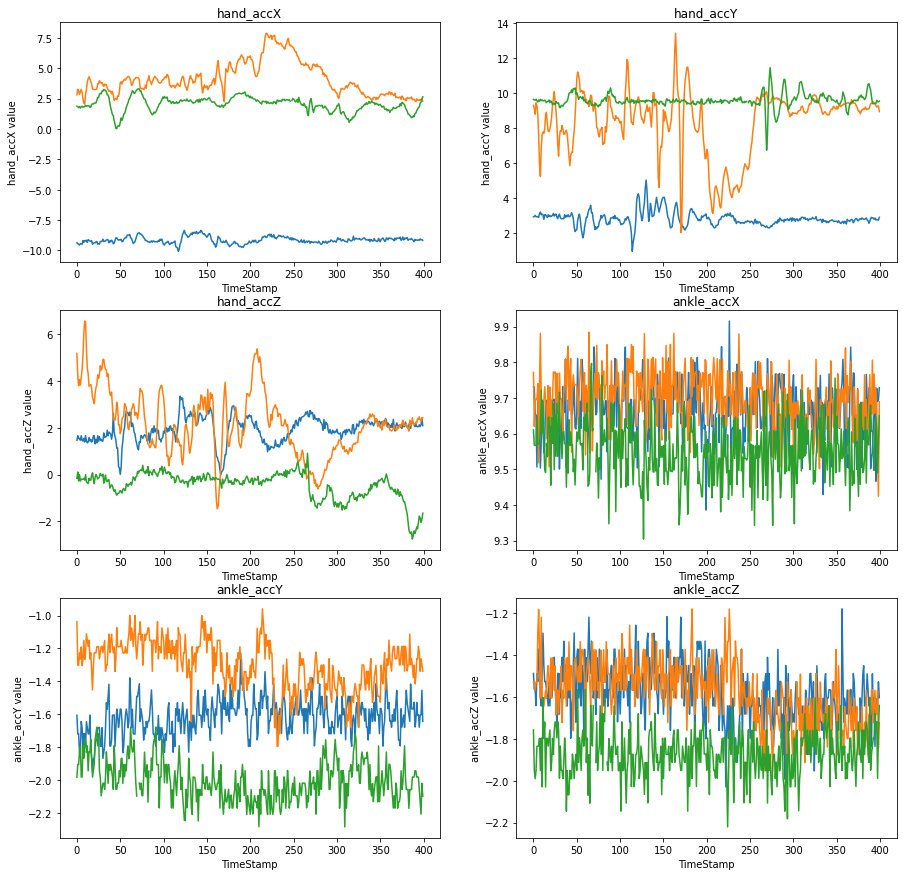

In [45]:
fig, axs = plt.subplots(3, 2, figsize=(15,15))
feat_cols = list(df.columns[3:9])
num_samples = 400
for idx, feat in enumerate(feat_cols):
  axs[idx//2, idx%2].plot([i for i in range(num_samples)], subject_1_walking[feat][:num_samples])
  axs[idx//2, idx%2].plot([i for i in range(num_samples)], subject_1_Running[feat][:num_samples])
  axs[idx//2, idx%2].plot([i for i in range(num_samples)], subject_1_Nordic[feat][:num_samples])
  axs[idx//2, idx%2].set_title(feat)
  axs[idx//2, idx%2].set_ylabel(f'{feat} value')
  axs[idx//2, idx%2].set_xlabel('TimeStamp')

## preprocess

I will perform the following preprocess:
1. Standart scale all sensor features: removing the mean and scaling to unit variance.

In [246]:
# Label encoder
le = preprocessing.LabelEncoder()
le.fit(df["activityID"].tolist())
df["activityID"] = le.transform(df["activityID"])
with open(f'{base_path}/labelencoder.pickle', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Standart Scale
standart_cols = ["hand_accX","hand_accY","hand_accZ","ankle_accX","ankle_accY",'ankle_accZ']
scaled_features = df.copy()
features = scaled_features[standart_cols]
scaler = preprocessing.StandardScaler().fit(features.values)
with open(f'{base_path}/scaler.pickle', 'wb') as handle:
    pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)
features = scaler.transform(features.values)


In [ ]:
# copy_df = copy.deepcopy(df)
# num_timestamps = 400

# # Reset index
# copy_df = copy_df.reset_index(drop = True)

# # Drop timestamp
# del copy_df["timestamp"]
# subject_samples = {}
# c = 0
# for subject in list(copy_df["subject_id"].unique()):
#     print(subject)
#     subject_df = copy_df[copy_df["subject_id"] == subject]
#     curr_subject_x, curr_subject_y = [], []
#     for i in range(subject_df.shape[0]-num_timestamps-1):
#         curr_df = subject_df.iloc[i:i+num_timestamps]
#         if curr_df.isnull().sum().sum() > 0:
#             continue
#         if curr_df["subject_id"].nunique() > 1 or curr_df["activityID"].nunique() > 1:
#             continue
#         y = curr_df_y = curr_df["activityID"].values[0]
#         del curr_df["subject_id"]
#         del curr_df["activityID"]
#         del curr_df["label_name"]
#         x = curr_df.values
#         curr_subject_x.append(np.array(x))
#         curr_subject_y.append(np.array(y))
#         c += 1
#     subject_samples[subject] = {}
#     subject_samples[subject]['x'] = np.array(curr_subject_x)
#     subject_samples[subject]['y'] = np.array(curr_subject_y)

1
2
3
4
6
7


In [3]:
with open(f'{base_path}/subject_samples.pickle', 'rb') as handle:
    subject_samples = pickle.load(handle)

In [ ]:
# import pickle

# with open('./subject_samples.pickle', 'wb') as handle:
#     pickle.dump(subject_samples, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(f'{base_path}/subject_samples.pickle', 'wb') as handle:
#     pickle.dump(subject_samples, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [6]:
for subject, val in subject_samples.items():
    print(f"Subject: {subject}, x: {val['x'].shape}, y: {val['y'].shape}")

Subject: 1, x: (1188, 400, 6), y: (1188,)
[0 0 0 ... 1 1 1]
Subject: 2, x: (2084, 400, 6), y: (2084,)
[0 0 0 ... 0 0 0]
Subject: 3, x: (2214, 400, 6), y: (2214,)
[0 0 0 ... 2 2 2]
Subject: 4, x: (6382, 400, 6), y: (6382,)
[0 0 0 ... 1 1 1]
Subject: 6, x: (2941, 400, 6), y: (2941,)
[0 0 0 ... 1 1 1]
Subject: 7, x: (2555, 400, 6), y: (2555,)
[0 0 0 ... 1 1 1]


## Model

In [249]:
subject1 = subject_samples[1]
enc = OneHotEncoder()
enc.fit(subject1['y'].reshape(-1, 1))
subject_y = enc.transform(subject1['y'].reshape(-1, 1)).toarray()
subject_x = subject1['x']
subject_x.shape, subject_y.shape
with open(f'{base_path}/OneHotEncoder.pickle', 'wb') as handle:
    pickle.dump(enc, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [63]:
def create_model(model_name, curr_subject, subject_samples):
  curr_subject = subject_samples[curr_subject]['x']
  if model_name == 'LSTM':
    model = Sequential()
    model.add(LSTM(50, input_shape=(curr_subject.shape[1], curr_subject.shape[2])))
    model.add(Dense(100,activation="relu"))
    model.add(Dense(3,activation="softmax"))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', 'AUC'])
    return model

  if model_name == 'CNN':
    model = Sequential()
    model.add(Conv2D(50, (1,5), padding="same", activation="relu", input_shape=(curr_subject.shape[1], curr_subject.shape[2],1)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100,activation="relu"))
    model.add(Dense(3,activation="softmax"))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', 'AUC'])
    return model

def get_x_y_from_subject(subject_num, enc, model_name):
  curr_sucject = subject_samples[subject_num]
  subject_y = enc.transform(curr_sucject['y'].reshape(-1, 1)).toarray()
  subject_x = curr_sucject['x']
  if model_name == 'CNN':
    subject_x = subject_x[:,:,:,np.newaxis]
  return subject_x, subject_y

def get_scores(preds, tesy_y):
  return accuracy_score(tesy_y.argmax(axis=1), preds.argmax(axis=1)), roc_auc_score(tesy_y, preds, multi_class='ovo', average='micro')

In [111]:
def random_prediction():
  zeros = np.zeros(3)
  zeros[np.random.randint(0,3)] = 1
  return zeros

In [238]:
# Cross validation
def run_leave_one_subject_one(subject_samples, model_name, naive_models):
  all_preds, all_ground_true = [], []
  print(model_name)
  results_row = {'algo': model_name}
  for idx, test_subject in enumerate(subject_samples):

    # print(f'Test: {test_subject}')
    model = create_model(model_name, test_subject, subject_samples)
    for train_subject in subject_samples:
      if model_name in naive_models:
        continue
      if train_subject == test_subject:
        continue
      train_x, train_y = get_x_y_from_subject(train_subject,enc, model_name)
      model.fit(train_x, train_y,verbose=0,epochs=10, batch_size = 128, shuffle=True)
    

    test_x, test_y = get_x_y_from_subject(test_subject,enc, model_name)
    if model_name in naive_models:
      if model_name == 'Highest_class':
        preds = np.array([[1,0,0] for i in range(test_x.shape[0])])
      if model_name == 'Random':
        preds = np.array([random_prediction() for i in range(test_x.shape[0])])

    else:
      preds = model.predict(test_x)
    acc, AUC = get_scores(preds, test_y)
    results_row[f'Fold{idx}_acc'] = acc
    results_row[f'Fold{idx}_auc'] = AUC
    all_preds.append(preds)
    all_ground_true.append(test_y)
  # print(results_row)
  results_row['preds'] = np.array([np.array(x) for val in all_preds for x in val])
  results_row['ground_true'] = np.array([np.array(x) for val in all_ground_true for x in val])
  return results_row

folds =  {}
algos_to_evaluate = ['LSTM','CNN', 'Highest_class', 'Random']
# algos_to_evaluate = ['Random']
for indx, algo in enumerate(algos_to_evaluate):
  folds[indx] = run_leave_one_subject_one(subject_samples, algo, ['Highest_class', 'Random'])

LSTM
CNN
Highest_class
Random


In [239]:
def get_avg_folds(x, met):
  vals = [val for key, val in x.items() if met in key]
  return np.mean(vals), np.std(vals)

In [240]:
results_df = pd.DataFrame.from_dict(folds).T
results_df["avg_folds_ACC"] = results_df.apply(lambda x: get_avg_folds(x, 'acc')[0], axis=1)
results_df["std_folds_ACC"] = results_df.apply(lambda x: get_avg_folds(x, 'acc')[1], axis=1)
results_df["avg_folds_AUC"] = results_df.apply(lambda x: get_avg_folds(x, 'auc')[0], axis=1)
results_df["std_folds_AUC"] = results_df.apply(lambda x: get_avg_folds(x, 'auc')[1], axis=1)

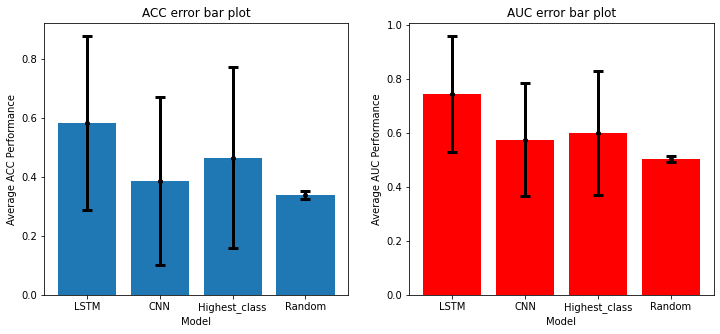

In [241]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,5))
metric = 'ACC'
ax1.errorbar( results_df['algo'], results_df[f'avg_folds_{metric}'], yerr=results_df[f'std_folds_{metric}'], fmt='o', color='Black', elinewidth=3,capthick=3,errorevery=1, alpha=1, ms=4, capsize = 5)
ax1.bar(results_df['algo'], results_df[f'avg_folds_{metric}'],tick_label = results_df['algo'])##Bar plot
ax1.set_xlabel('Model') ## Label on X axis
ax1.set_ylabel(f'Average {metric} Performance') ##Label on Y axis
ax1.set_title(f"{metric} error bar plot")

metric = 'AUC'
ax2.errorbar( results_df['algo'], results_df[f'avg_folds_{metric}'], yerr=results_df[f'std_folds_{metric}'], fmt='o', color='Black', elinewidth=3,capthick=3,errorevery=1, alpha=1, ms=4, capsize = 5)
ax2.bar(results_df['algo'], results_df[f'avg_folds_{metric}'],tick_label = results_df['algo'], color='red')##Bar plot
ax2.set_xlabel('Model') ## Label on X axis
ax2.set_ylabel(f'Average {metric} Performance') ##Label on Y axis
ax2.set_title(f"{metric} error bar plot")
plt.show()

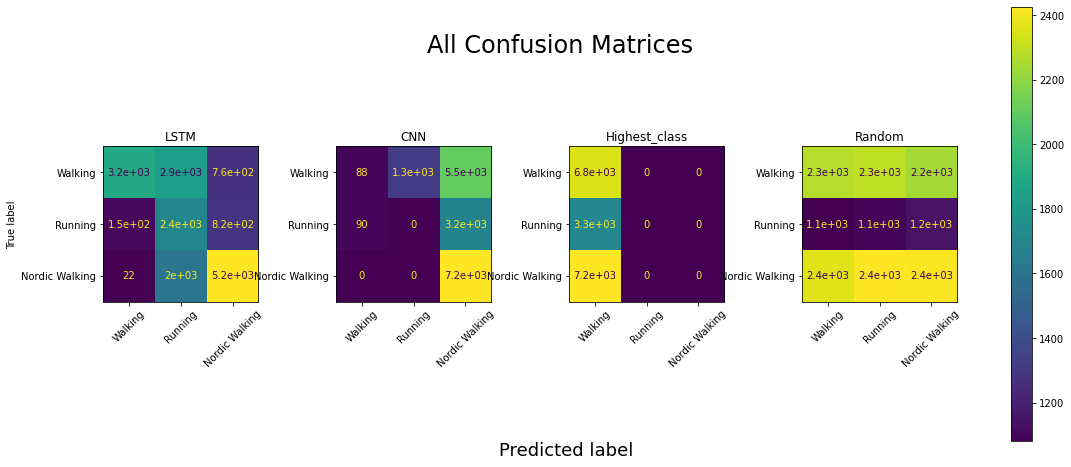

In [242]:
f, axes = plt.subplots(1, 4,figsize=(20,8))
for i, key in enumerate(algos_to_evaluate):
  cf_matrix = confusion_matrix(results_df["ground_true"].values[i].argmax(axis=1), results_df["preds"].values[i].argmax(axis=1))
  disp = ConfusionMatrixDisplay(cf_matrix,
                                display_labels=['Walking','Running','Nordic Walking'])
  disp.plot(ax=axes[i], xticks_rotation=45)
  disp.ax_.set_title(key)
  disp.im_.colorbar.remove()
  disp.ax_.set_xlabel('')
  if i!=0:
      disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left', fontdict = {'fontsize' : 18})
f.text(0.35, 0.8,"All Confusion Matrices", fontdict = {'fontsize' : 24})
f.colorbar(disp.im_, ax=axes)
plt.show()

#### To Add:
4. Create a further EDA
5. Write the results in text
8. Save One-hot Encoder and starndart scaler, label-encoder
5. Create the predict function
